> ### Imports

In [1]:
import os
import numpy as np
import pandas as pd

from iqual import tests

C:\Users\Aditya\.conda\envs\pyaudio\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Aditya\.conda\envs\pyaudio\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Aditya\.conda\envs\pyaudio\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


> ### Load datasets

In [2]:
data_dir    = "../data"

### Qualitative data (Enhanced Data with progressive k-fold bootstrap)
bootstrap_df  = pd.read_csv(os.path.join(data_dir,"enhanced_bootstrap_kfold.csv"))

### Quantitative data
quant_df      = pd.read_csv(os.path.join(data_dir,"quant_data.csv"))

> ### Variables

In [3]:
annotation_vars = ["ability_low","job_secular"]

id_vars         = ['uid','split','data_round','refugee','bootstrap_run','train_sample_size']

> ### Enhanced Bootstrap Dataframe (Merged with quantiative data)

In [4]:
bootstrap_df = bootstrap_df[[*id_vars,*annotation_vars]].copy()
bootstrap_df = pd.merge(bootstrap_df,quant_df,on=['uid','data_round','refugee'],how='left')

> ### Regression Configuration

In [5]:
# Numerical regressors (Continuous/Dummy variables)
numerical_vars = [
     'refugee',"int_sex", "int_age",
     'hh_head_sex',
     'eld_sex',
     'parent_reledu',
     'num_child',
     'hh_head_age',
     'parent_eduyears',
     'eld_age',
     'hh_asset_index',
     'hh_income',
     'int_trauma_exp',
]

In [6]:
import itertools
HUMAN_SIZES    = [100, 200, 400, 700]
MACHINE_SIZES  = [200, 400, 600, 800, 1000, 1200, 1400]
BOOTSTRAP_RUNS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [117]:
N_DRAWS        = 100

In [118]:
coefs        = []
random_draws = np.random.normal(size=N_DRAWS)


for ANNOTATION, REGRESSOR in [('job_secular','eld_sex'),('ability_low','refugee')]:

    for h, r, m in itertools.product(HUMAN_SIZES, BOOTSTRAP_RUNS, MACHINE_SIZES):
        
        print("\r...| ","Bootstrap Run:",r,"Human:",h,"Machine:",m,sep=' ',end=' | ...')
        
        df = bootstrap_df[(bootstrap_df['train_sample_size']==h) & (bootstrap_df['bootstrap_run']==r)]
        
        # Separate human and machine data
        human_df   = df[df.split == 'train']
        # Sample machine data
        machine_df = df[df.split != 'train'].sample(m)
        # Concatenate human and machine data for enhanced data
        enh_df     = pd.concat([human_df, machine_df])

        # Run regression on human 
        human_model = tests.Interpretability(human_df,annotation_vars=[ANNOTATION],numerical_regressors=numerical_vars).fit_all()
        # Human model coefficient and standard error
        human_coef = human_model.get_model_coefficient(ANNOTATION,REGRESSOR)
        human_se   = human_model.get_model_std_error(ANNOTATION,REGRESSOR)

        
        # Run regression on enhanced data
        enh_model  = tests.Interpretability(enh_df,annotation_vars=[ANNOTATION],numerical_regressors=numerical_vars).fit_all()
        # Enhanced model coefficient and standard error
        enh_coef = enh_model.get_model_coefficient(ANNOTATION,REGRESSOR)
        enh_se   = enh_model.get_model_std_error(ANNOTATION,REGRESSOR)
        
        
        # Random draws from normal distribution
        for random_draw in random_draws:
            # Bootstrap (Human) coefficient
            human_boot_coef = human_coef + random_draw*human_se
            
            # Bootstrap (Enhanced) coefficient
            enh_boot_coef = enh_coef + random_draw*enh_se
            
            coefs.append({
                'annotation': ANNOTATION,'regressor': REGRESSOR,
                'human_coef': human_coef,'human_se':human_se,
                'enh_coef': enh_coef,'enh_se':enh_se,
                'human_boot_coef': human_boot_coef,
                'enh_boot_coef': enh_boot_coef,
                'bootstrap_run':r,'n_h': h,'n_m': m,
        })

coef_data = pd.DataFrame(coefs)

...|  Bootstrap Run: 10 Human: 700 Machine: 1400 | ...

In [119]:
coef_data.head()

,annotation,regressor,human_coef,human_se,enh_coef,enh_se,human_boot_coef,enh_boot_coef,bootstrap_run,n_h,n_m
0,job_secular,eld_sex,-0.067084,0.030005,-0.022509,0.016509,-0.109631,-0.045918,1,100,200
1,job_secular,eld_sex,-0.067084,0.030005,-0.022509,0.016509,-0.013866,0.006772,1,100,200
2,job_secular,eld_sex,-0.067084,0.030005,-0.022509,0.016509,-0.095379,-0.038077,1,100,200
3,job_secular,eld_sex,-0.067084,0.030005,-0.022509,0.016509,-0.097807,-0.039412,1,100,200
4,job_secular,eld_sex,-0.067084,0.030005,-0.022509,0.016509,-0.029257,-0.001697,1,100,200


> ## Regression Coefficient Plots

In [120]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [121]:
keep_cols = ['annotation','regressor','human_boot_coef','enh_boot_coef','bootstrap_run','n_h','n_m']

> ### `Low Ability` (Coefficient on `Refugee`)

In [122]:
ANNOTATION, REGRESSOR = 'ability_low','refugee'

C:\Users\Aditya\AppData\Local\Temp\ipykernel_32312\3739677127.py:51: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000017B692D5400> has a label of '_child15' which cannot be automatically added to the legend.
  fig.legend(handles=[human_patch, enhanced_patch], loc='upper right', ncol=2)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_32312\3739677127.py:51: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000017C3A0CB3A0> has a label of '_child16' which cannot be automatically added to the legend.
  fig.legend(handles=[human_patch, enhanced_patch], loc='upper right', ncol=2)


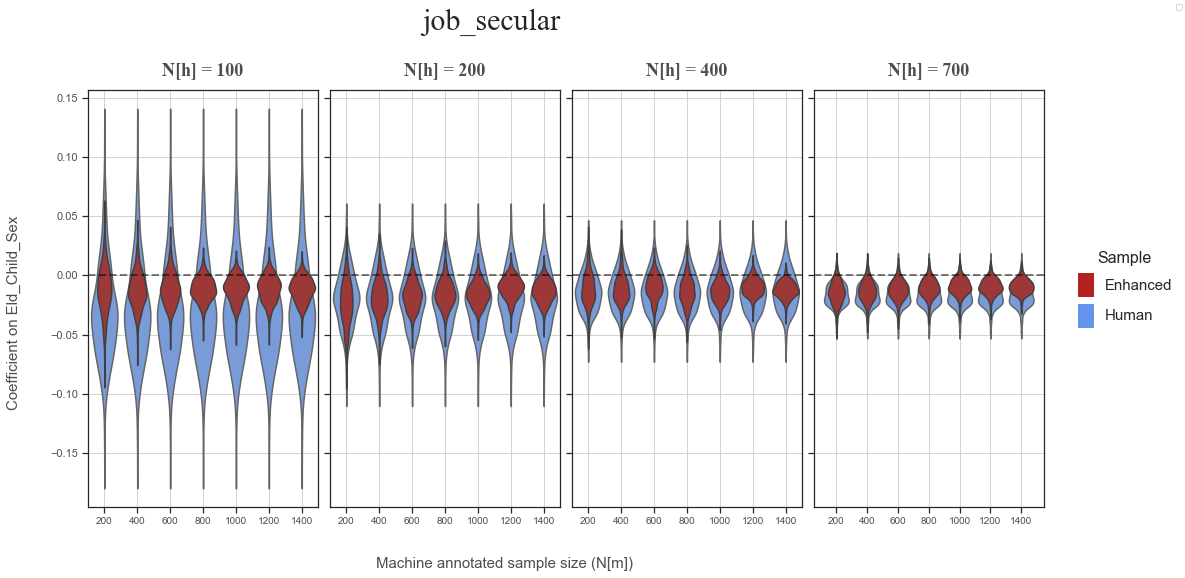

In [136]:
coef_df = coef_data.loc[(coef_data['annotation']==ANNOTATION),keep_cols]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,8), sharey=True, sharex=False)

fig.suptitle(ANNOTATION,x=0.4, y=0.99, fontfamily='Times New Roman',fontsize=30,)

# Iterate over N(h) 
for i, human_size in enumerate(HUMAN_SIZES):  
    # Get axis
    ax = axs[i]
    
    # Select subset [n_h = human_size]
    
    df = coef_df[(coef_df['n_h']==human_size)]    
    
    # Zeroline (dashed)    
    ax.axhline(y=0, ls='--',color='black',alpha=0.5, lw=2)
    
    # Human sample
    sns.violinplot(x=df['n_m'],y=df['human_boot_coef'],
                   ax=ax,dodge=False,inner=None,saturation=0.7,color='cornflowerblue',
                   name=None
                  )
    
    # Enhanced sample
    sns.violinplot(x=df['n_m'],y=df['enh_boot_coef'],
                   ax=ax,dodge=False,inner=None,saturation=0.7,color='firebrick',
                   name=None
                  )
        
    # Removing redundant xy axis labels
    ax.set(ylabel=None,xlabel=None)
    ax.tick_params(axis='y',labelsize=11, labelcolor='#4e4e4e')
    ax.tick_params(axis='x',labelsize=10, labelcolor='#4e4e4e')
    
    ax.grid(True, lw=1, c='lightgray')
    
    # Subplot title    
    ax.set_title(f"N[h] = {human_size}",fontdict={'family':'Times New Roman',
                                            'fontsize':18,
                                            'color':'#4e4e4e',
                                            'fontweight':800
                                           },
                 pad=15
                )    

    
# Add legends
human_patch = plt.plot([], [], color='cornflowerblue', marker='s', markersize=10, linestyle='')[0]
enhanced_patch = plt.plot([], [], color='firebrick',  marker='s', markersize=10, linestyle='')[0]
fig.legend(handles=[human_patch, enhanced_patch], loc='upper right', ncol=2)

# Y-axis label
fig.text(-0.02, 0.3,f"Coefficient on {REGRESSOR.title()}",rotation='vertical',
         fontdict={"fontsize":15,'color':"#4e4e4e"},
        )
# X-axis label
fig.text(0.3, 0.02,f"Machine annotated sample size (N[m])",
         fontdict={"fontsize":15,'color':"#4e4e4e"},
        )

# Layout

# Legend
patches = [
    mpatches.Patch(color='firebrick', label='Enhanced'),
    mpatches.Patch(color='cornflowerblue', label='Human'),    
          ]
fig.legend(handles=patches,
           title='Sample',
           title_fontsize=16,
           fontsize=15,
           ncol=1,labelspacing=0.5,           
           handlelength=1,handleheight=2,        
           loc='center right',frameon=False,
         )
plt.subplots_adjust(top=0.85,wspace=0.05,right=0.88,left=0.05)
plt.show()

> ### `Secular Aspirations` (Coefficient on `Female eldest child`)

In [134]:
ANNOTATION, REGRESSOR = 'job_secular','eld_child_sex'

C:\Users\Aditya\AppData\Local\Temp\ipykernel_32312\2197644448.py:51: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000017B25E8A700> has a label of '_child15' which cannot be automatically added to the legend.
  fig.legend(handles=[human_patch, enhanced_patch], loc='upper right', ncol=2)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_32312\2197644448.py:51: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000017B24C5F3A0> has a label of '_child16' which cannot be automatically added to the legend.
  fig.legend(handles=[human_patch, enhanced_patch], loc='upper right', ncol=2)


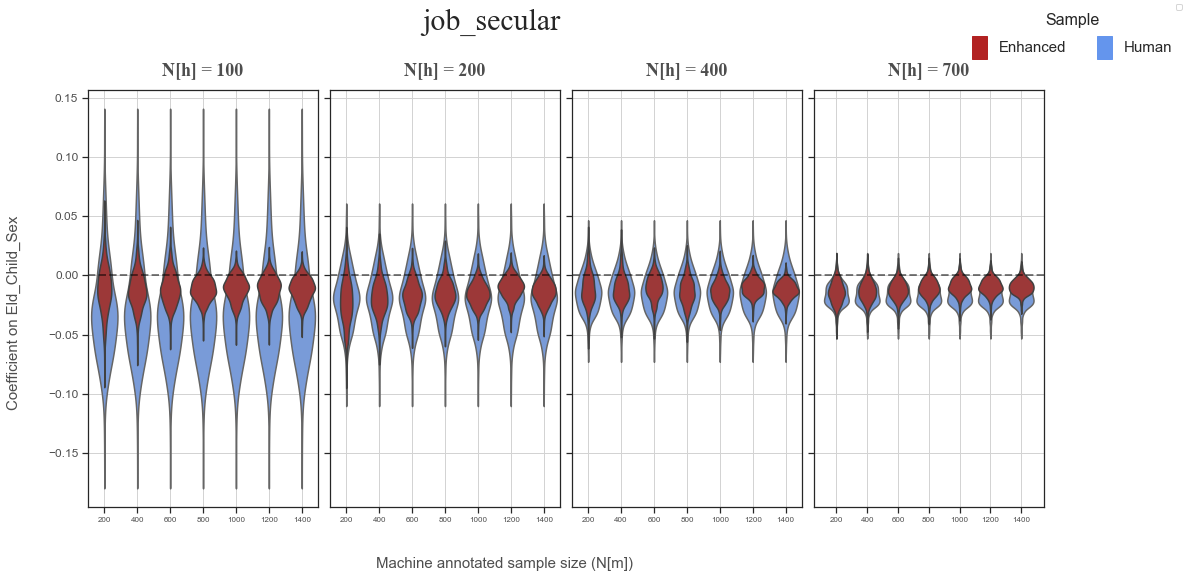

In [139]:
coef_df = coef_data.loc[(coef_data['annotation']==ANNOTATION),keep_cols]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,8), sharey=True, sharex=False)

fig.suptitle(ANNOTATION,x=0.4, y=0.99, fontfamily='Times New Roman',fontsize=30,)

# Iterate over N(h) 
for i, human_size in enumerate(HUMAN_SIZES):  
    # Get axis
    ax = axs[i]
    
    # Select subset [n_h = human_size]
    
    df = coef_df[(coef_df['n_h']==human_size)]    
    
    # Zeroline (dashed)    
    ax.axhline(y=0, ls='--',color='black',alpha=0.5, lw=2)
    
    # Human sample
    sns.violinplot(x=df['n_m'],y=df['human_boot_coef'],
                   ax=ax,dodge=False,inner=None,saturation=0.7,color='cornflowerblue',
                   name=None
                  )
    
    # Enhanced sample
    sns.violinplot(x=df['n_m'],y=df['enh_boot_coef'],
                   ax=ax,dodge=False,inner=None,saturation=0.7,color='firebrick',
                   name=None
                  )
        
    # Removing redundant xy axis labels
    ax.set(ylabel=None,xlabel=None)
    ax.tick_params(axis='y',labelsize=12, labelcolor='#4e4e4e')
    ax.tick_params(axis='x',labelsize=8, labelcolor='#4e4e4e')
    
    ax.grid(True, lw=1, c='lightgray')
    
    # Subplot title    
    ax.set_title(f"N[h] = {human_size}",fontdict={'family':'Times New Roman',
                                            'fontsize':18,
                                            'color':'#4e4e4e',
                                            'fontweight':800
                                           },
                 pad=15
                )    

    
# Add legends
human_patch = plt.plot([], [], color='cornflowerblue', marker='s', markersize=10, linestyle='')[0]
enhanced_patch = plt.plot([], [], color='firebrick',  marker='s', markersize=10, linestyle='')[0]
fig.legend(handles=[human_patch, enhanced_patch], loc='upper right', ncol=2)

# Y-axis label
fig.text(-0.02, 0.3,f"Coefficient on {REGRESSOR.title()}",rotation='vertical',
         fontdict={"fontsize":15,'color':"#4e4e4e"},
        )
# X-axis label
fig.text(0.3, 0.02,f"Machine annotated sample size (N[m])",
         fontdict={"fontsize":15,'color':"#4e4e4e"},
        )

# Layout

# Legend
patches = [
    mpatches.Patch(color='firebrick', label='Enhanced'),
    mpatches.Patch(color='cornflowerblue', label='Human'),    
          ]
fig.legend(handles=patches,
           title='Sample',
           title_fontsize=16,
           fontsize=15,
           ncol=2,labelspacing=0.5,           
           handlelength=1,handleheight=2,        
           loc='upper right',frameon=False,
         )
plt.subplots_adjust(top=0.85,wspace=0.05,right=0.88,left=0.05)
plt.show()